# 신경망을 이용한 로지스틱 회귀 분석 

**참고**  
이 노트북은 **[Coursera Deep Learning](https://www.coursera.org/learn/neural-networks-deep-learning/home/welcome)** 강좌를 가져온 자료입니다.  
복습겸 오래된 버전의 패키지로 인해 작동안하는 걸 수정했습니다.   
물론 Coursera 에서 제공하는 노트북은 예전 버전의 패키지로 세팅되어있어 잘 돌아갑니다.


**핵심 내용:**
    - 매개변수 초기화
    - cost function & gradient 계산
    - 최적화 알고리즘 

## 1 - 패키지 ##

- [numpy](www.numpy.org) 행렬에 대한 수식에 필요한 패키지입니다.
- [h5py](http://www.h5py.org) h5 형식 파일을 사용할때 필요한 패키지입니다.
- [matplotlib](http://matplotlib.org) 시각화에 사용할 패키지입니다.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) 모델 테스트 그리고 테스트 결과를 확인하기 위한 패키지입니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

## 2 - 해결할 문제 ##

**주어진 데이터셋("data.h5")에 저장된 내용:**
    - 고양이 사진(y=1) 고양이가 아닌 사진(y=0)으로 라벨링된 m개의 학습데이터
    - 고양이와 고양이가 아닌 사진으로 라벨링된 m개의 검정데이터
    - 각 사진의 구조는 (num_px, num_px, 3)입니다.3은 색상 채널을 의미하고 RGB 3개 색상을 포함하고 있습니다. 
    
여러분은 고양이와 고양이가 아닌 사진을 구별 또는 인식하는 간단한 이미지 인식 알고리즘을 구축할겁니다.

데이터를 불러 직접 확인해보겠습니다

In [2]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

이미지 데이터셋에 전처리 과정이 필요하기 때문에 데이터셋(train, test)의 변수명에 "_orig" 을 붙였습니다.   
전처리 이후 이미지 데이터의 변수명은 train_set_x, test_set_x 로 사용할 겁니다.  
(label 데이터인 y는 전처리가 필요 없습니다.)

train_set_x_orig 과 test_set_x_orig 은 행렬 형태의 이미지를 포함하고 있습니다.  
변수 index의 값을 수정해서 어떤 이미지를 갖고있는지 확인해보세요~

(209, 64, 64, 3) (1, 209) (50, 64, 64, 3) (1, 50)
[1]
y = [0], it's a 'non-cat' picture.


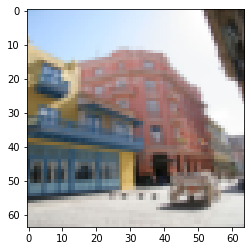

In [3]:
# Example of a picture
index = 23
plt.imshow(train_set_x_orig[index])

print(train_set_x_orig.shape, train_set_y.shape, test_set_x_orig.shape, test_set_y.shape)

print(train_set_y[:, 25])

print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

흔히 딥러닝 모델의 오류는 행렬의 차원을 제대로 맞추지 않아서 발생하게 됩니다. 미리 행렬의 차원 값을 고정으로 한다면 오류를 사전에 예방할 수 있습니다.

**실습 :** 
    - m_train (학습 데이터 갯수)
    - m_test (검정 데이터 갯수)
    - num_px (이미지의 높이와 너비)
    

`train_set_x_orig` 의 행렬 구조가 (m_train, num_px, num_px, 3) 이라는것을 꼭 기억하세요 !!

예를 들어 `train_set_x_orig.shape[0]` 사용하면 m_train(학습 데이터 갯수)를 확인 할수 있습니다.

In [4]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = test_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Expected Output for m_train, m_test and num_px**: 
<table style="width:15%">
  <tr>
    <td> m_train </td>
    <td> 209 </td> 
  </tr>
    
  <tr>
    <td> m_test </td>
    <td> 50 </td> 
  </tr>
    
  <tr>
    <td> num_px </td>
    <td> 64 </td> 
  </tr>
</table>


추후에 간변한 계산을 위해 데이터 이미지의 구조를 변형시켜야합니다.  
현재 이미지의 구조(num_px, num_px, 3)에서 (num_px $*$ num_px $*$ 3, 1) 로 변형시켜야합니다.

이러한 작업을 거치면 각 데이터셋은 칼럼은 평평하게 변한 이미지를 의미하게 됩니다.



**Exercise:** 학습데이터와 검정데이터의 이미지 구조를 변형시켜보세요~
X의 행렬구조 (a,b,c,d)를 (b $*$ c $*$ d, a)로 바꾸는 방법:
```python
X_flatten = X.reshape(X.shape[0], -1).T
```

In [5]:
train_set_x_orig.shape

(209, 64, 64, 3)

In [13]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T

test_set_x_flatten = test_set_x_orig.reshape(m_test, -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0])) # 첫번째 ~ 다섯번째 행의 첫번째 값을 가져오는 건데
                                                                           # 제대로 변형이 됐는지 확인하고자하는 부분입니다.
print(train_set_x_orig[0][0][0:5])

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]
[[17 31 56]
 [22 33 59]
 [25 35 62]
 [25 35 62]
 [27 36 64]]


In [7]:
print(train_set_x_flatten.shape)

(12288, 209)


**Expected Output**: 

<table style="width:35%">
  <tr>
    <td>train_set_x_flatten shape</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>train_set_y shape</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>test_set_x_flatten shape</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>test_set_y shape</td>
    <td>(1, 50)</td> 
  </tr>
  <tr>
  <td>sanity check after reshaping</td>
  <td>[17 31 56 22 33]</td> 
  </tr>
</table>

색상 이미지를 표현하기 위해서는 각 한 픽셀에 3색 원소가 지정되어야합니다. 그래서 한 픽셀은 3개 값을 갖고있는 벡터라고 표현합니다. 그리고 각 색 원소의 값은 0~255 값을 갖고있습니다.

일반적인 데이터의 머신러닝 전처리 과정에서는 전체 행렬에 전체 평균 값을 빼고 표준 편차값으로 나눠주는 표준화 작업을 수행하는데 이미지 데이터에 대해서는 간단하게 모든 값을 최댓값인 255로 나눠주는 표준화 작업을 합니다.


<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

In [14]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

#print(test_set_x, test_set_x.shape)
#print(test_set_y, test_set_y.shape)

<font color='blue'>
**중요한 내용:**

새로운 데이터에 대해 전처리 하는 과정:
- 데이터의 차원과 구조를 확인합니다.
- 각 데이터를 표현하기 쉽게 그리고 계산하기 쉽게 구조를 변형시킵니다.
- 각 값에 대해 표준화를 수행합니다.

## 3 - 일반적인 학습 알고리즘의 구조 ##

이제 고양이를 구분하는 간단한 알고리즘을 만들어보겠습니다.

신경망으로 로지스틱 회귀식을 만들어보겠습니다. 아래 사진은 왜 로지스틱 회귀가 가장 간단한 신경망인지 설명합니다.


<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**수식 설명**:

한개 이미지 $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

비용은 학습데이터의 전부를 합한 값으로 구합니다.:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**핵심 단계**:
이번 과제에서는 다음 단계를 순서로 진행합니다.: 
    - 모델의 매개변수 초기화
    - 비용을 최소화 시키는 매개변수를 학습
    - 학습된 매개변수를 검정 데이터로 예측
    - 결과에 대한 분석

## 4 - 알고리즘의 각 구조 설계 ## 

신경망을 만들기 위한 핵심 단계:
1. 모델의 구조를 정의합니다.  
2. 매개변수를 초기화 합니다
3. 반복:
    - 순전파를 통해 현재 손실값을 계산합니다.
    - 계산한 손실값과 역전파를 통해 현재 경사도를 계산합니다.
    - 구한 경사도를 통해 매개변수 값을 업데이트합니다.

1-3 단계를 따로 만들고 이후에 model() 함수로 한번에 모아 작업할 겁니다.

### 4.1 - Helper functions

**Exercise**:  위 사진에서 수식같이, 예측하기 위해서는 $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ 계산이 필요합니다. np.exp()을 사용하세요~.

In [15]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1 / (1 + np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [16]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


In [17]:
np.array([2, 3]).shape

(2,)

**Expected Output**: 

<table>
  <tr>
    <td>sigmoid([0, 2])</td>
    <td> [ 0.5         0.88079708]</td> 
  </tr>
</table>

### 4.2 - 매개변수 초기화

**Exercise:** 아래 하단에 있는 cell로 매개변수를 초기화합니다. w 벡터 값을 0으로 초기화 해야합니다. numpy 기능을 잘 모르신다면 numpy 공식 문서에서 np.zeros()에 대해 확인해보세요~

In [20]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros((dim, 1))
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [21]:
dim = 2
w, b = initialize_with_zeros(dim) # 입력되는 dim은 입력할 행 개수를 의미합니다.
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


**Expected Output**: 


<table style="width:15%">
    <tr>
        <td>   w   </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>   b   </td>
        <td> 0 </td>
    </tr>
</table>

For image inputs, w will be of shape (num_px $\times$ num_px $\times$ 3, 1).

### 4.3 - 순전파와 역전파 

매개변수를 초기화했다면 이제 순전파와 역잔파를 통해 매개변수를 학습시킵니다.

**Exercise:** 아래 cell에 있는 propagate를 실행시켜 비용함수와 기울기를 계산해보세요~

**Hints**:

순전파:
- 입력 변수 X
- X로 A값 계산 $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- A로 비용함수 계산: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

역전파를 계산하기 위한 미분값은 아래 식으로 구합니다: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [22]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b) # compute activation
    
    cost = -np.sum((np.dot(Y, np.log(A).T) + np.dot((1-Y), np.log(1-A).T)))/m
    cost2 = -(np.dot(Y, np.log(A).T) + np.dot((1-Y), np.log(1-A).T))/m
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = 1/m * (np.dot(X, (A-Y).T))
    # dw 는 
    
    
    db = 1/m * np.sum(A-Y)
    
    
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost) # squeeze는 불필요한 차원을 줄어주는 역할을 합니다
                            # ex) (2, 1) ==> (2, ) 또는 (2, 2, 1)  ==> (2, 2)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [23]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1., 2., -1.],[3., 4., -3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


In [24]:
print(w.shape)
print(b)
print(X.shape)
print(Y.shape)

(2, 1)
2.0
(2, 3)
(1, 3)


**Expected Output**:

<table style="width:50%">
    <tr>
        <td>   dw   </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>   db   </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>   cost   </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### 4.4 - 최적화
- 매개변수를 초기화 했습니다.
- 비용함수를 계산하고 미분값 또한 구했습니다.
- 이제 경사하강도를 통해 매개변수를 업데이트 합니다.

**Exercise:** 

비용함수 값 $J$를 최소화하는 $w$ 와 $b$ 를 학습하는것이 최적화의 목표입니다.

예시 매개변수 $\theta$의 업데이트 방법은 $ \theta = \theta - \alpha \text{ } d\theta$, $\alpha$ 는 학습률입니다.

In [25]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        m = X.shape[1] 
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - (learning_rate * dw)
        b = b - (learning_rate * db)
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [26]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067652


**Expected Output**: 

<table style="width:40%">
    <tr>
       <td> w </td>
       <td>[[ 0.19033591]
 [ 0.12259159]] </td>
    </tr>
    <tr>
       <td> b </td>
       <td> 1.92535983008 </td>
    </tr>
    <tr>
       <td> dw </td>
       <td> [[ 0.67752042]
 [ 1.41625495]] </td>
    </tr>
    <tr>
       <td> db </td>
       <td> 0.219194504541 </td>
    </tr>

</table>

**Exercise:** 이전 함수로 계산한 결과로 학습된 w와 b를 구했습니다. 이제 w와 b를 사용해 새롭게 입력되는 데이터의 라벨을 예측할 수 있게 됐습니다. `predict()` 함수를 사용해 다음 두 단계를 진행합니다.


1.  $\hat{Y} = A = \sigma(w^T X + b)$ 예측값 계산

2. 계산된 값이 0.5보다 작은 값(이하)이 나온다면 0으로 0.5보다 큰 값이 나오면 1로 변환해줍니다. 변환한 값은 `Y_prediction` 변수에 벡터형태로 저장합니다.


In [27]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T, X) + b)
    
    ### END CODE HERE ###
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        if A[:, i] > 0.5:
             Y_prediction[:, i] = 1
        else:
             Y_prediction[:, i] = 0
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [28]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


**Expected Output**: 

<table style="width:30%">
    <tr>
         <td>
             **predictions**
         </td>
          <td>
            [[ 1.  1.  0.]]
         </td>  
   </tr>

</table>


<font color='blue'>
**중요한 것:**  
    
You've implemented several functions that:  
- (w,b) 초기화  
- 손실을 최소화하기 위해 매개변수 (w,b)를 반복적 학습:  
    - 비용함수과 미분값 계산  
    - 역전파를 통해 매개변수 업데이트  
- 학습된 (w,b)로 입력되는 데이터의 label 예측  

## 5 - 모든 기능 합체!! ##

이제 여태 만들었던 기능을 한곳에 모으면 모델의 전체적인 구조와 과정을 볼 수 있습니다.

**Exercise:** 아래 변수명을 사용합니다:
    - Y_prediction_test 은 검정데이터에 대한 예측 값
    - Y_prediction_train 은 학습데이터에 대한 예측 값
    - w, costs, grads 들은 `optimize()`의 결과 값입니다.

In [29]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0]) # w는 X의 입력데이터 수와 같은 구조를 갖고있어야합니다
    
    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    # 훈련데이터를 통해 w를 최적화
            
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train) # 예측값을 가져오고

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Run the following cell to train your model.

In [30]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Expected Output**: 

<table style="width:40%"> 
    <tr>
        <td> **Cost after iteration 0 **  </td> 
        <td> 0.693147 </td>
    </tr>
    <tr>
        <td> <center> $\vdots$ </center> </td> 
        <td> <center> $\vdots$ </center> </td> 
    </tr>  
    <tr>
        <td> **Train Accuracy**  </td> 
        <td> 99.04306220095694 % </td>
    </tr>
    <tr>
        <td>**Test Accuracy** </td> 
        <td> 70.0 % </td>
    </tr>
</table> 




**Comment**: 학습데이터에 대한 정확도는 100%에 가깝게 나옵니다. 일단 모델이 학습데이터 한해서 좋은 성과를 나온다 말할 수 있습니다. 하지만 검정데이터의 정확도는 68%입니다. 사실 이렇게 간단한 모델에 적은 데이터로 학습했는데 이정도 정확도는 나쁘지 않은 결과입니다. 

또한 학습데이터에 과대적합을 확인할 수 있습니다. 다음 다른 과제에서 규제화 또는 다른 방법으로 과대적합을 줄이는 방법에 대해 공부해보겠습니다.

y = 0, you predicted that it is a "non-cat" picture.


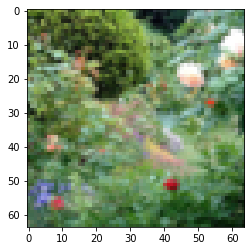

In [48]:
# Example of a picture that was wrongly classified.
index = 49
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))

print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

비용함수값과 미분값을 시각화 해봅시다

[0.69314718 0.58450836 0.46694904 0.37600687 0.33146329 0.30327307
 0.27987959 0.26004214 0.24294068 0.22800422 0.21481951 0.20307819
 0.19254428 0.18303334 0.17439859 0.1665214  0.15930452 0.15266732
 0.14654224 0.14087208]


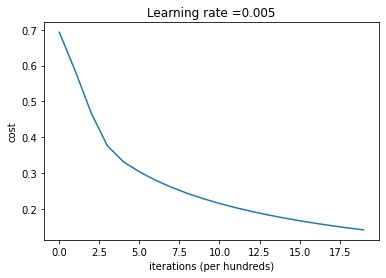

In [49]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
print(costs)
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

In [50]:
print(d['costs'])

[0.6931471805599453, 0.5845083636993086, 0.46694904094655476, 0.37600686694802077, 0.33146328932825125, 0.30327306747438293, 0.27987958658260487, 0.26004213692587574, 0.24294068467796623, 0.2280042225672607, 0.21481951378449637, 0.20307819060644988, 0.1925442771670686, 0.18303333796883506, 0.17439859438448882, 0.16652139705400332, 0.15930451829756614, 0.15266732471296504, 0.14654223503982342, 0.14087207570310162]


**Interpretation**:
비용함수 값이 줄어드는것을 확인했습니다. 이것은 매개변수 w와 b가 잘 학습된다는 의미입니다. 
그리고 좀 더 많이 학습시킬 수 있습니다.
하지만 학습 데이터에 대한 정확도는 높아지지만 검정 데이터에 대한 정확도는 낮아지는 것을 확인할 수 있을 겁니다. 이것을 과대적합이라고 표현합니다.

## 6 - 심화 분석 ##
학습률(learning rate: $a$) 에 대해 좀더 알아보겠습니다.

#### 학습률 선택 방법 ####

**Reminder**:
학습률($a$)는 매개변수가 얼마나 빠르게 업데이트 될지 결정합니다. 따라서 역전파를 통해 학습시킬때는 학습률을 현명하게 선택해야합니다.
만약 학습률이 너무 크면 발산하게 되고 유사하게 너무 낮게 설정하면 학습을 엄청나게 해야 최적의 값을 찾을 수 있을겁니다.

아래 cell을 실행시켜 학습률에 따른 차이를 직접 확인해봅시다.

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



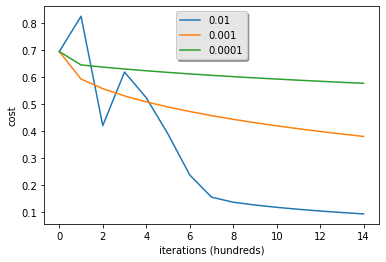

In [51]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**결과 해석**: 
- 학습률에 따라 예측결과와 비용함수 값이 다릅니다/
- 학습률이 너무 크다면(여기서 0.01) 비용함수 값의 변동이 큰 것을 확인 할 수 있습니다. (이번 예시에서는 좋은 결과를 가져왔지만 잘 못 학습될 수 도 있습니다.)
- 낮은 비용함수 값을 갖는 모델이 무조건 좋은 모델이라고 할 수 없습니다. 만약 과대적합의 가능성이 있다면 꼭 확인해봐야합니다. 
- 딥러닝시 추천하는 방법: 
    - 비용함수값을 더 잘 최소화 하는 학습률을 선택하세요
    - 과대적합 문제가 발생하면 다른 방법을 사용하세요


## 7 - 개인적인 사진으로 결과 확인 ##

y = 0.0, your algorithm predicts a "non-cat" picture.


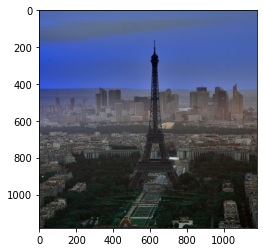

In [64]:
my_image = "la_defense.jpg"   # change this to the name of your image file 

import cv2
# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = cv2.imread(fname)
image = image/255.
my_image = cv2.resize(image, dsize=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

테스트 데이터의 정확도가 70%이지만 잘 인식 못하네요~~ ㅎㅎ

<font color='blue'>  
**이번 내용으로 기억해야할 점!!:**    
1. 데이터 전처리는 중요한 과정입니다.
2. 여러 기능을 따로 구현을 했습니다. 구현한 기능들: initialize(), propagate(), optimize(). 그리고 model()으로 한번에 모아 설계했습니다.
3. 합습률 조정에 따라 알고리즘에 큰 차이의 영향을 미칩니다. (이러한 변수를 하이퍼파라미터라고 합니다.)

- 학습률 그리고 학습횟수를 바꿔가면서 결과를 확인해보세요~
- 다른 초기화 방법을 찾아보고 결과를 비교해보세요~
- 다른 전처리 방법을 찾아보고 결과를 비교해보세요~

Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c